<a href="https://colab.research.google.com/github/eloiberlinger1/yolo12_climbing_seg/blob/main/yolo12_test_climbing_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [2]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 92.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Getting dataset

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
!cp drive/MyDrive/yolo_format.zip .
!unzip yolo_format.zip

Archive:  yolo_format.zip
   creating: yolo_format/
  inflating: __MACOSX/._yolo_format  
  inflating: yolo_format/.DS_Store   
  inflating: __MACOSX/yolo_format/._.DS_Store  
   creating: yolo_format/images/
  inflating: __MACOSX/yolo_format/._images  
   creating: yolo_format/labels/
  inflating: __MACOSX/yolo_format/._labels  
   creating: yolo_format/masks/
  inflating: __MACOSX/yolo_format/._masks  
  inflating: yolo_format/images/massy_block_image_66.png  
  inflating: __MACOSX/yolo_format/images/._massy_block_image_66.png  
  inflating: yolo_format/images/massy_block_image_72.png  
  inflating: __MACOSX/yolo_format/images/._massy_block_image_72.png  
  inflating: yolo_format/images/bup_brezet_block_image_48.png  
  inflating: __MACOSX/yolo_format/images/._bup_brezet_block_image_48.png  
  inflating: yolo_format/images/madrid-carabanchel_block_image_12.png  
  inflating: __MACOSX/yolo_format/images/._madrid-carabanchel_block_image_12.png  
  inflating: yolo_format/images/euromede

In [57]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class LocalYOLODataset(Dataset):
    def __init__(self, images_directory, annotations_directory, masks_directory=None, transform=None):
        self.images_directory = images_directory
        self.annotations_directory = annotations_directory
        self.masks_directory = masks_directory
        self.transform = transform
        self.image_files = os.listdir(images_directory)
        self.location = os.getcwd()+"/yolo_format"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.images_directory, img_name)
        image = Image.open(img_path).convert("RGB")

        annotation_path = os.path.join(self.annotations_directory, img_name.replace('.jpg', '.txt'))
        with open(annotation_path, 'r') as file:
            annotations = file.readlines()

        # Parse polygon annotations
        polygons = []
        for annotation in annotations:
            parts = annotation.strip().split()
            class_id = int(parts[0])
            coords = list(map(float, parts[1:]))
            polygon = {'class_id': class_id, 'coords': coords}
            polygons.append(polygon)

        if self.masks_directory:
            mask_path = os.path.join(self.masks_directory, img_name.replace('.jpg', '.png'))
            mask = Image.open(mask_path)
        else:
            mask = None

        sample = {'image': image, 'polygons': polygons, 'mask': mask}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

# Usage
dataset = LocalYOLODataset(
    images_directory=f"{HOME}/yolo_format/images",
    annotations_directory=f"{HOME}/yolo_format/labels",
    masks_directory=f"{HOME}/yolo_format/masks"  # Optional
)


In [58]:
!ls {dataset.location}

images	labels	masks


# Make split

In [59]:
import os
import argparse
from pathlib import Path
import random
import shutil

def count_annotated_images(dataset_path):
    """
    Compte le nombre d'images annotées dans le dataset
    """
    images_dir = Path(dataset_path) / "images"
    labels_dir = Path(dataset_path) / "labels"

    if not images_dir.exists() or not labels_dir.exists():
        raise ValueError(f"Le dataset {dataset_path} doit contenir les répertoires 'images' et 'labels'")

    # Compter les images qui ont une annotation correspondante
    annotated_count = 0
    for image_file in images_dir.glob("*.png"):
        label_file = labels_dir / f"{image_file.stem}.txt"
        if label_file.exists():
            annotated_count += 1

    return annotated_count

def create_split_directories(base_path):
    """
    Crée les répertoires pour le split train/val/test
    """
    splits = ['train', 'valid', 'test']
    for split in splits:
        for subdir in ['images', 'labels', 'masks']:
            (base_path / split / subdir).mkdir(parents=True, exist_ok=True)

def copy_files(image_name, src_path, dst_path):
    """
    Copie les fichiers (image, label, mask) d'une image vers le répertoire de destination
    """
    # Copier l'image
    src_image = src_path / "images" / f"{image_name}.png"
    dst_image = dst_path / "images" / f"{image_name}.png"
    shutil.copy2(src_image, dst_image)

    # Copier le label
    src_label = src_path / "labels" / f"{image_name}.txt"
    dst_label = dst_path / "labels" / f"{image_name}.txt"
    shutil.copy2(src_label, dst_label)

    # Copier le mask s'il existe
    src_mask = src_path / "masks" / f"{image_name}_mask.png"
    if src_mask.exists():
        dst_mask = dst_path / "masks" / f"{image_name}_mask.png"
        shutil.copy2(src_mask, dst_mask)

def split_dataset(dataset_path, train_ratio, val_ratio):
    """
    Divise le dataset en train/val/test selon les ratios spécifiés
    """
    dataset_path = Path(dataset_path)

    # Récupérer la liste des images annotées
    images = []
    for image_file in (dataset_path / "images").glob("*.png"):
        if (dataset_path / "labels" / f"{image_file.stem}.txt").exists():
            images.append(image_file.stem)

    # Mélanger aléatoirement les images
    random.shuffle(images)

    # Calculer les indices de séparation
    n_images = len(images)
    n_train = int(n_images * train_ratio)
    n_val = int(n_images * val_ratio)

    # Diviser les images
    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]

    # Créer les répertoires
    create_split_directories(dataset_path)

    # Copier les fichiers
    for img in train_images:
        copy_files(img, dataset_path, dataset_path / "train")
    for img in val_images:
        copy_files(img, dataset_path, dataset_path / "valid")
    for img in test_images:
        copy_files(img, dataset_path, dataset_path / "test")

    # Afficher les statistiques
    print(f"\nSplit terminé :")
    print(f"Train : {len(train_images)} images ({train_ratio*100:.1f}%)")
    print(f"Val   : {len(val_images)} images ({val_ratio*100:.1f}%)")
    print(f"Test  : {len(test_images)} images ({(1-train_ratio-val_ratio)*100:.1f}%)")





dataset_path = dataset.location
train_ratio = 70 / 100
val_ratio = 20 / 100




n_images = count_annotated_images(dataset_path)
test_ratio = 1 - train_ratio - val_ratio
print(f"\nLe dataset contient {n_images} images annotées.")
print(f"\nRépartition effectuée :")
print(f"Train : {int(n_images * train_ratio)} images ({train_ratio*100:.1f}%)")
print(f"Val   : {int(n_images * val_ratio)} images ({val_ratio*100:.1f}%)")
print(f"Test  : {int(n_images * test_ratio)} images ({test_ratio*100:.1f}%)")

# Effectuer le split
split_dataset(dataset_path, train_ratio, val_ratio)


Le dataset contient 560 images annotées.

Répartition effectuée :
Train : 392 images (70.0%)
Val   : 112 images (20.0%)
Test  : 56 images (10.0%)

Split terminé :
Train : 392 images (70.0%)
Val   : 112 images (20.0%)
Test  : 56 images (10.0%)


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [60]:
!echo -e "names:\n- Wall\ntest: test/images\ntrain: train/images\nval: valid/images" >> {dataset.location}/data.yaml


ajouter au fichier data.yaml

```

train: train/images
val: valid/images
test: test/images

# Path to segmentation masks
train_masks: train/masks
val_masks: valid/masks
test_masks: test/masks

nc: 1 # Number of classes
names: ['Wall']  # List of class names

```



In [78]:
!cat {dataset.location}/data.yaml

train: train/images
val: valid/images
test: test/images

# Path to segmentation masks
train_labels: train/labels
val_labels: valid/labels
test_labels: test/labels

nc: 1 # Number of classes
names: ['Wall']  # List of class names

## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [79]:
from ultralytics import YOLO

model = YOLO('yolo11s-seg.pt')
results = model.train(data=f'{dataset.location}/data.yaml', epochs=5)

New https://pypi.org/project/ultralytics/8.3.96 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=segment, mode=train, model=yolo11s-seg.pt, data=/content/yolo_format/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

train: Scanning /content/yolo_format/train/labels.cache... 392 images, 0 backgrounds, 0 corrupt: 100%|██████████| 392/392 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolo_format/valid/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100%|██████████| 112/112 [00:00<?, ?it/s]


Plotting labels to runs/segment/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/segment/train3
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.48G     0.6548      2.741      2.066      1.249         26        640: 100%|██████████| 25/25 [00:06<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

                   all        112        112     0.0761      0.824     0.0757     0.0411     0.0787      0.874     0.0776     0.0412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.25G     0.6001     0.7309     0.6942      1.164         22        640: 100%|██████████| 25/25 [00:06<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.20it/s]

                   all        112        112   0.000485     0.0357   0.000144   2.23e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.24G     0.5749     0.6807     0.5605      1.123         27        640: 100%|██████████| 25/25 [00:06<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.05it/s]

                   all        112        112       0.65      0.375      0.468      0.243       0.58      0.357      0.428       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.22G     0.5256     0.5222     0.4771      1.085         25        640: 100%|██████████| 25/25 [00:06<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.18it/s]

                   all        112        112      0.965      0.971      0.993      0.849      0.956      0.962      0.988      0.656



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.24G     0.4903     0.5528     0.4423      1.079         28        640: 100%|██████████| 25/25 [00:06<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.08it/s]

                   all        112        112      0.982      0.998      0.994      0.795      0.982      0.998      0.994      0.839



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train3/weights/last.pt, 20.5MB
Optimizer stripped from runs/segment/train3/weights/best.pt, 20.5MB

Validating runs/segment/train3/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11s-seg summary (fused): 265 layers, 10,067,203 parameters, 0 gradients, 35.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


                   all        112        112      0.982      0.998      0.994      0.794      0.982      0.998      0.994      0.839
Speed: 0.1ms preprocess, 2.9ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/segment/train3


## Evaluate fine-tuned YOLOv12 model

In [80]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1742894699.8ff925983d1a.1755.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


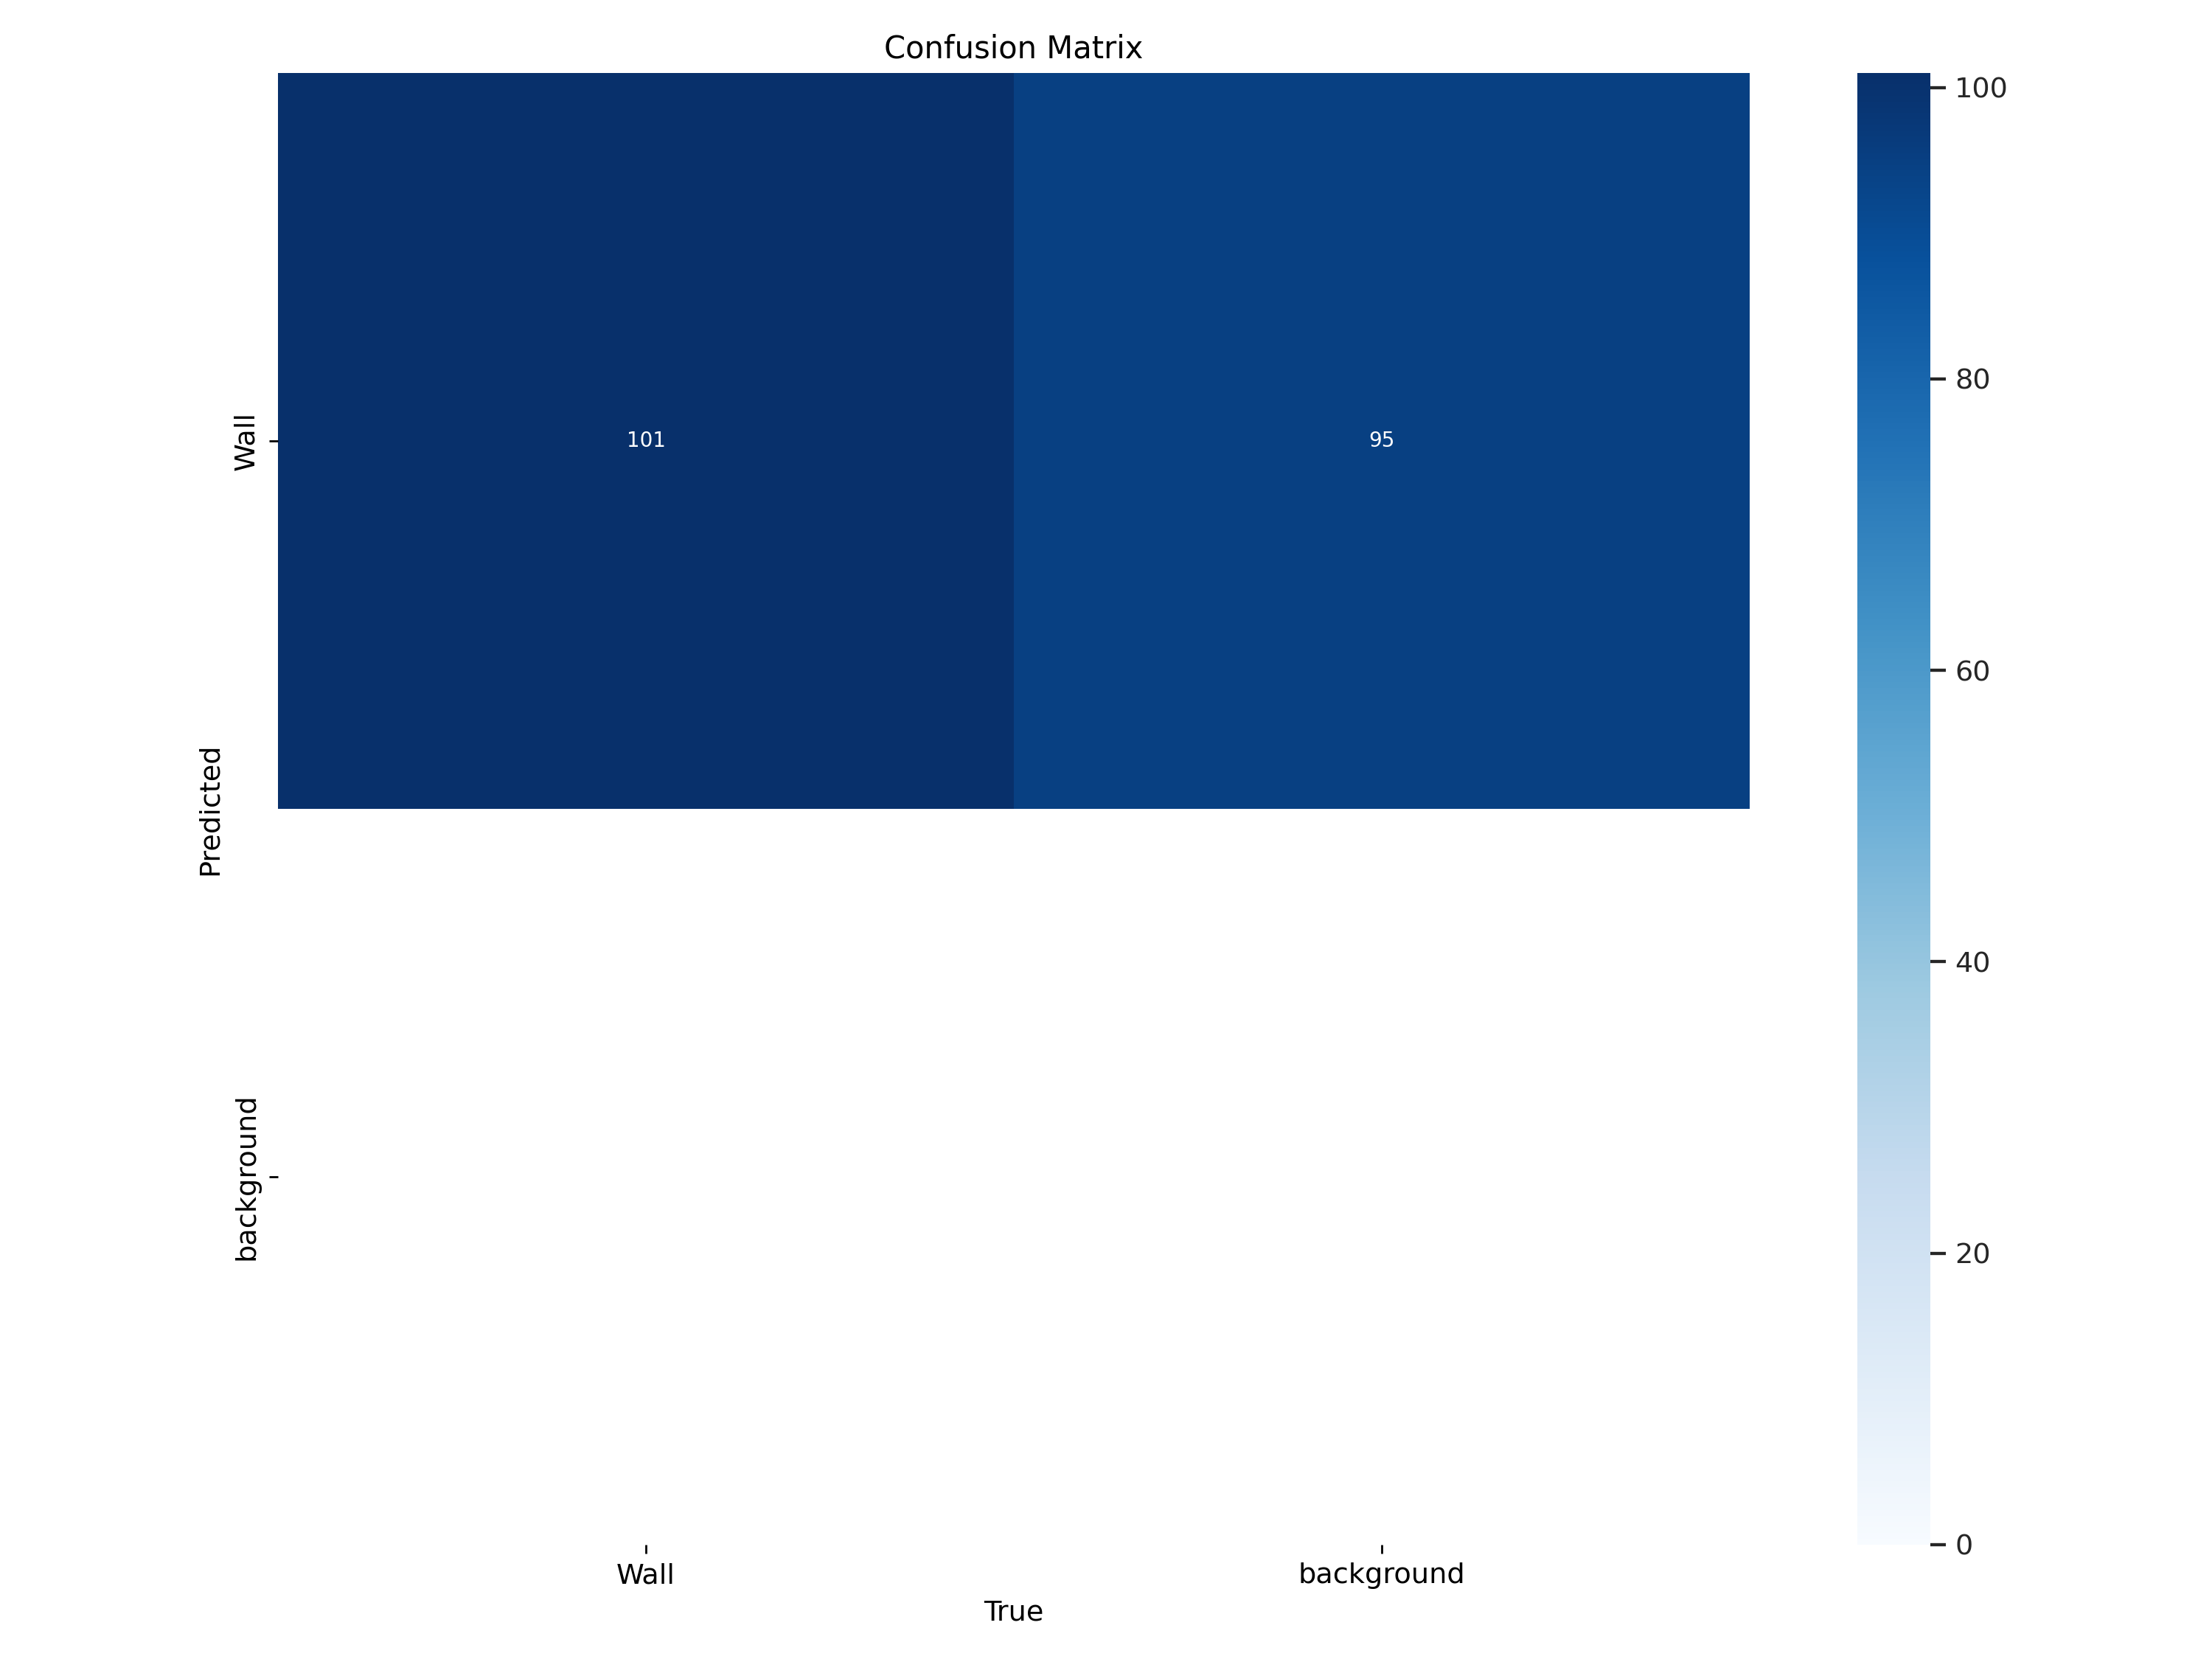

In [67]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

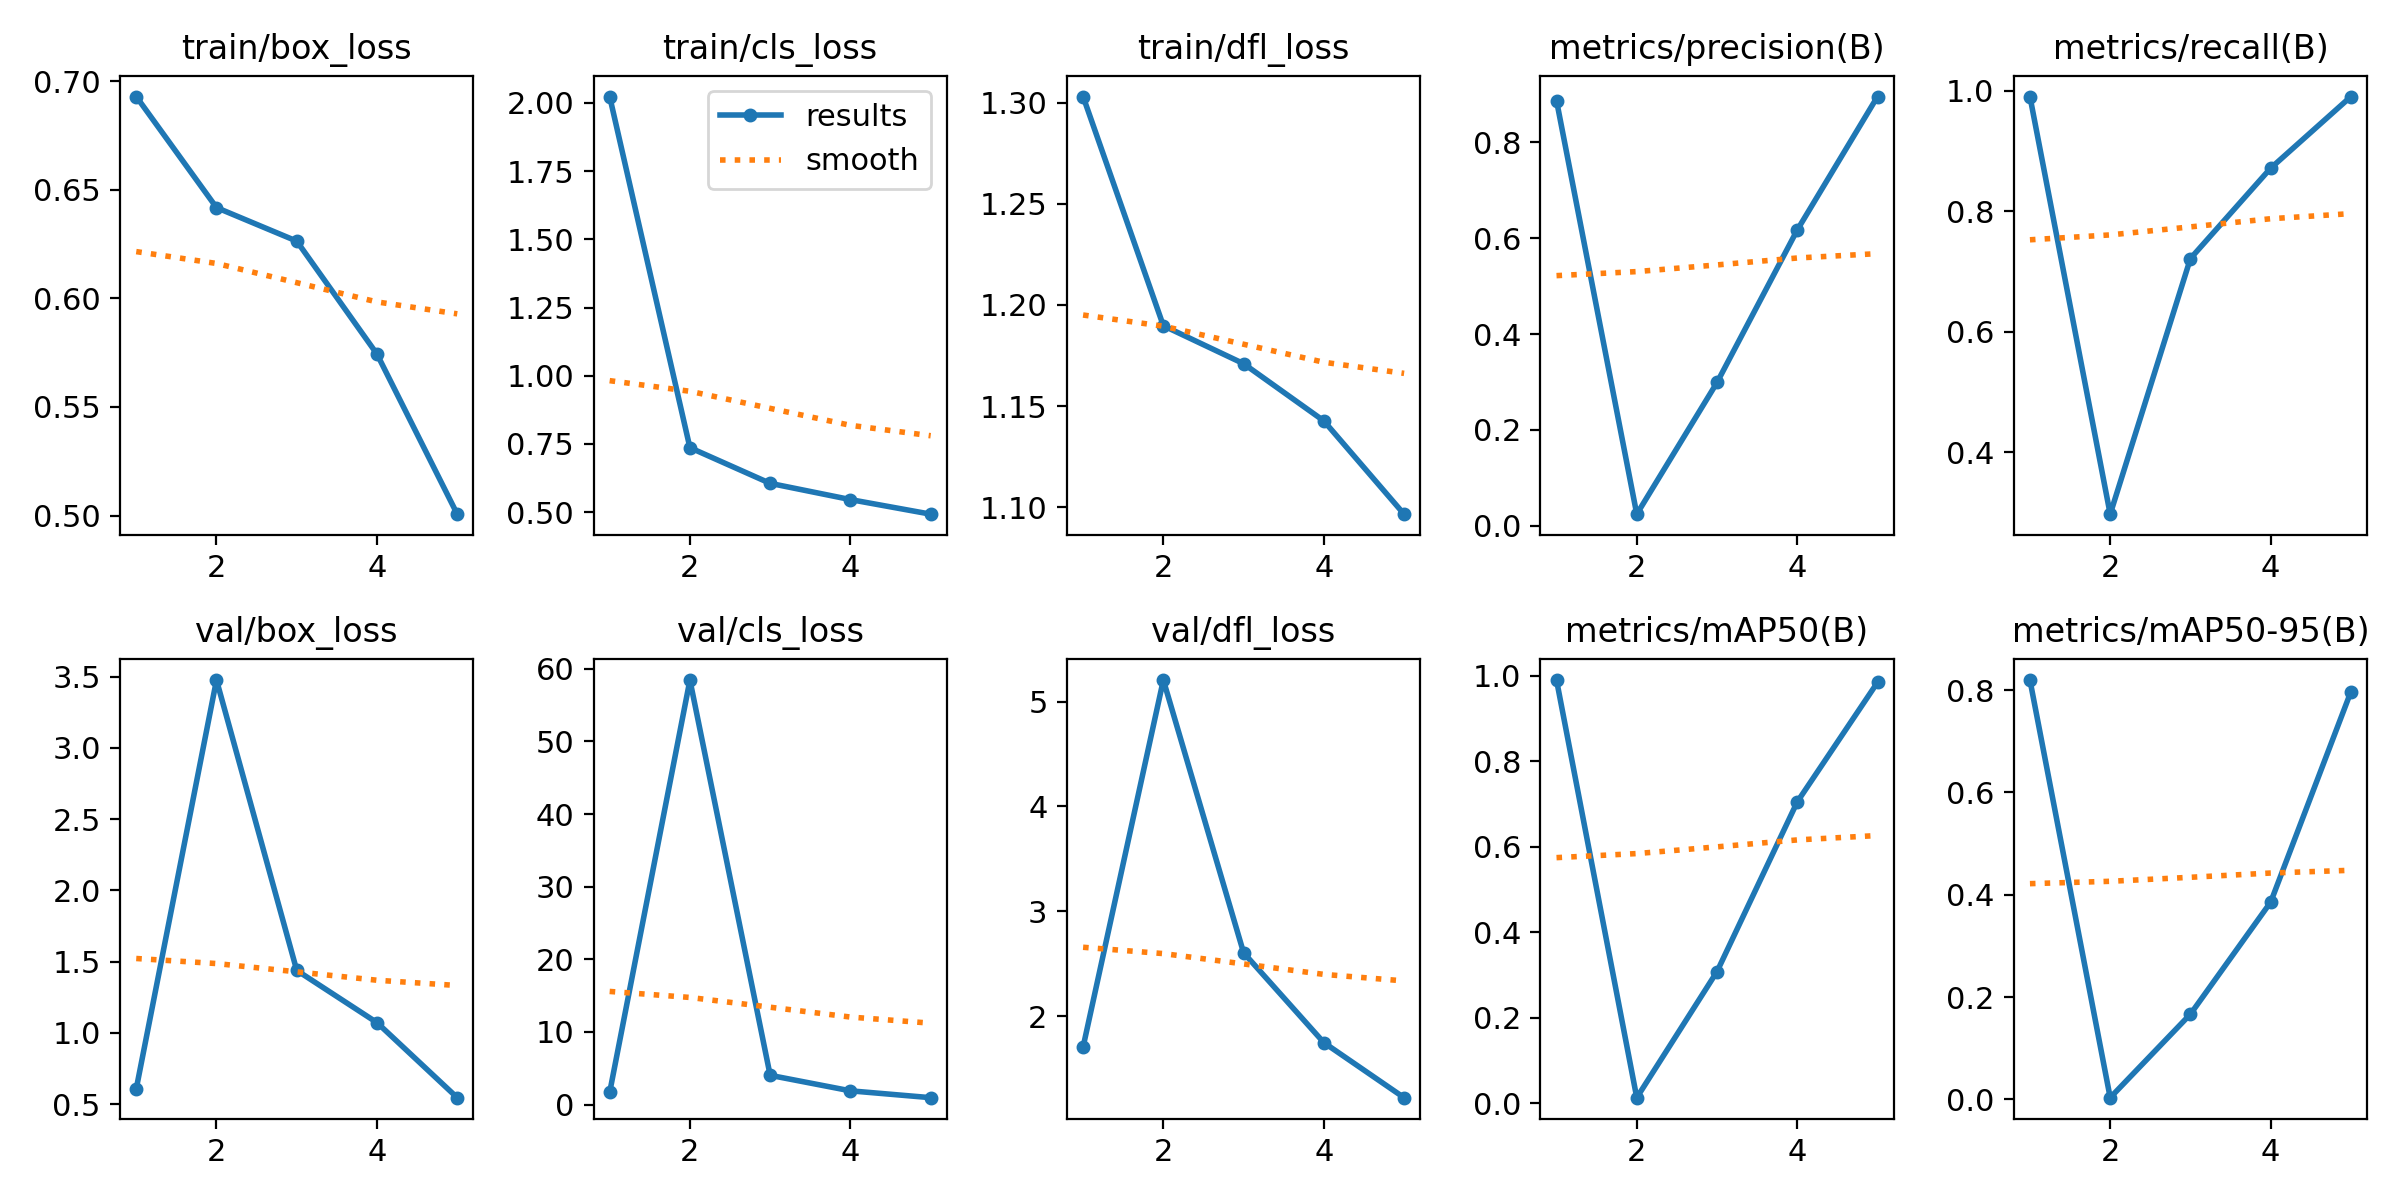

In [68]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [81]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['Wall']

In [82]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [83]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7998530929647207
mAP 50 0.9738069153128345
mAP 75 0.8747912827991047


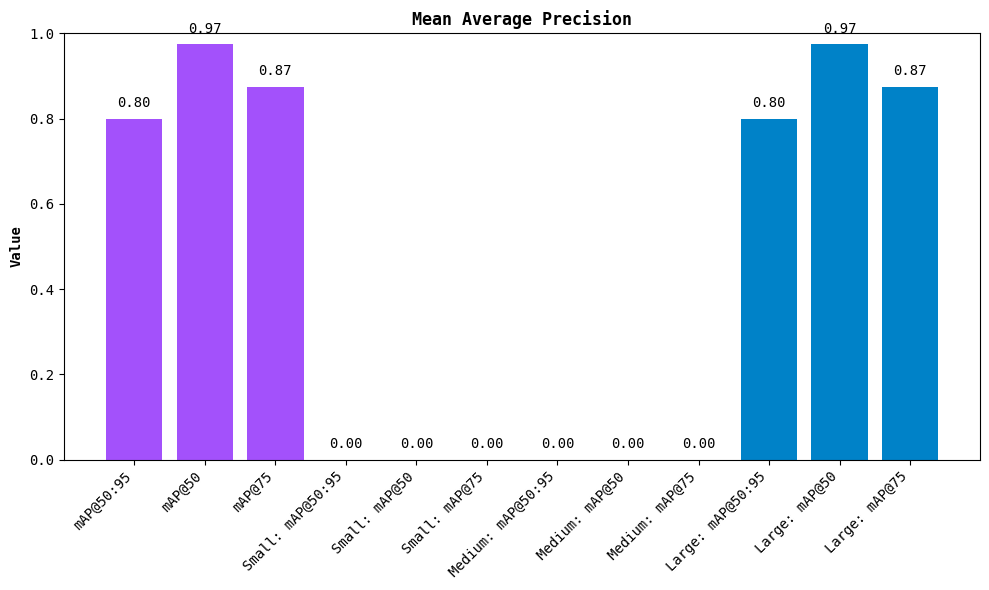

In [84]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [122]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/segment/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

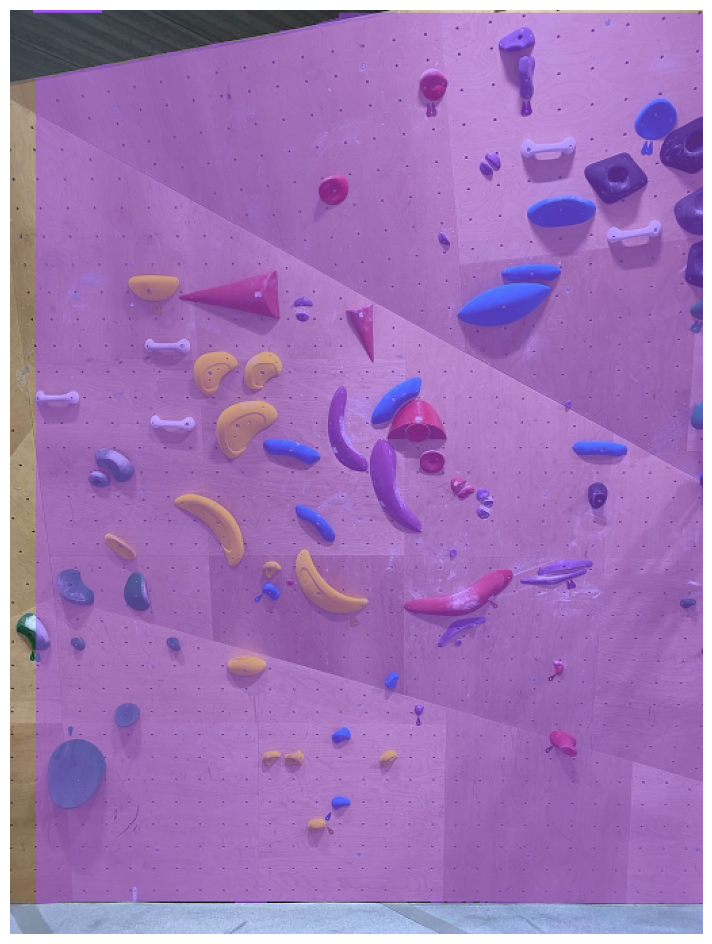

In [135]:
import random
import supervision as sv
from ultralytics import YOLO
import cv2

# Assurez vous que model est un modèle de segmentation (yolo...-seg.pt)
i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

mask_annotator = sv.MaskAnnotator()  # Utilisation de MaskAnnotator
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = mask_annotator.annotate(scene=annotated_image, detections=detections) # Annotation des masques
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)